# Balancing and distinguishing minority class investigation. 

The primary goal of this notebook is to build a robust machine learning model capable of effectively predicting true positives in a highly imbalanced dataset with significant missing values. We focus on improving the model's performance through a series of preprocessing steps, feature engineering, dimensionality reduction, and hyperparameter tuning.

### Data Characteristics
- Imbalanced Dataset: The dataset has a significantly skewed class distribution, with only 10% of the samples belonging to the positive class.
- High Proportion of Missing Values: Approximately 92% of the dataset contains missing values, necessitating effective handling strategies.


### Steps and Techniques Implemented
1. Data Cleaning and Preprocessing

2. Missing Value Imputation

3. Standardization

4. Variance Threshold
5. Dimensionality Reduction

6. SMOTE(Synthetic Minority Over-sampling Technique)
7. LightGBM with hyperparameter tunning and regularization
8. Comparison with the baseline at each step

In [0]:
pip install umap-learn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Not uninstalling numpy at /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-6f83af8f-03d2-4828-8948-8181a6304c1d
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
databricks-feature-store 0.12.1 requires pyspark<4,>=3.1.2, wh

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer  # Required to enable the IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import os
import warnings
import mlflow
warnings.filterwarnings('ignore', category=UserWarning)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ffb5e31b250>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
'''
#  Set the working directory
os.chdir('c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/machine-learning-dse-i210-final-project-credit-risk/notebooks')
# Set data paths
data_dir = 'c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/new_aggs/new_aggs/'
data_base = 'C:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Project_final/home-credit-credit-risk-model-stability/csv_files/train/train_base.csv'
'''

"\n#  Set the working directory\nos.chdir('c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/machine-learning-dse-i210-final-project-credit-risk/notebooks')\n# Set data paths\ndata_dir = 'c:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Final Project/new_aggs/new_aggs/'\ndata_base = 'C:/Users/laura/OneDrive/Documentos/Personal Documents/Universidad/DSE CCNY/Courses Semester 2/Applied ML/Project_final/home-credit-credit-risk-model-stability/csv_files/train/train_base.csv'\n"

In [0]:
mlflow.autolog(disable=True)

# Load the data

We will use the union of the personal and non personal data after begin preprocessed. In this stage we will use just a set of that. This same code will be later run again with the complete dataset to get the final scores on the complete data.

In [0]:
path1='/dbfs/FileStore/LEM_TEST/df1.pkl'
path2='/dbfs/FileStore/LEM_TEST/df2.pkl'

# Read the pickle files into pandas DataFrames
df1 = pd.read_pickle(path1)
df2 = pd.read_pickle(path2)


In [0]:
## Same code as in model/le_baseline_model
'''
# Load the .pkl file for the personal data
file1 = data_dir + 'df1.pkl'
df = pd.read_pickle(file1)

# Load the .pkl file for the non personal data
file2 = data_dir + 'df2.pkl'
df2 = pd.read_pickle(file2)
'''
# Joing the applicant personal data and the non personal one to get the complete dataset.
df_full = df1.merge(df2, on=['case_id', 'date_decision', 'WEEK_NUM'], how='left')

# dropping the extra target column that appeared because of the join and it is just a duplicate of the target
df_full.rename(columns={'target_x': 'target'}, inplace=True)

# Drop target_y
df_full.drop(columns=['target_y'], inplace=True)

# Extra Data Cleaning

We futher clean the data to be able to feed the previously stated predictors.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [0]:
# Convert date_decision to timestamp
df_full["date_decision"] = pd.to_datetime(df_full["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
bool_columns = df_full.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    df_full[col] = df_full[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = df_full.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    df_full[col] = df_full[col].replace({None: np.nan, True: 1.0, False: 0.0})


## 1. Removing Columns where Missing data is more than 95% 

In [0]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
df_filtered = df_full[df_full.columns[df_full.isnull().mean() < missing_threshold]]

Check the shapes of the dataset pre and post change

In [0]:
df_full.shape

(10000, 2638)

In [0]:
df_filtered.shape

(10000, 1879)

## Train and Validation Split. 

We remove the target from the training datasets. We then further split the dataset into train and validation. For this split we will startify based on the target so we ge the same proportion on positives clases in both splits

In [0]:
# Train and Validation split
base = df_filtered[["case_id", "WEEK_NUM", "target"]]
X = df_filtered.drop(columns=["case_id", "WEEK_NUM", "target"])
y = df_filtered["target"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

# Prepare base_train and base_valid
base_train = base.iloc[X_train.index]
base_valid = base.iloc[X_valid.index]


# 2. Imputation Missing values

First, we will KNN based Imputation. 

https://www.freecodecamp.org/news/how-to-handle-missing-data-in-a-dataset/

In [0]:
# Fit KNN imputer on training data
knn_imputer = KNNImputer(n_neighbors=5)
X_train_knn_imputed_5 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Apply KNN imputer to validation data
X_valid_knn_imputed_5 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

In [0]:
# Fit KNN imputer on training data
knn_imputer = KNNImputer(n_neighbors=10)
X_train_knn_imputed_10 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Apply KNN imputer to validation data
X_valid_knn_imputed_10 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

In this section we try MICE imputation. It was cancelled due to the long time to compute

In [0]:
# Use IterativeImputer with a simpler estimator like ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
iterative_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, n_jobs=-1, random_state=42), random_state=42, max_iter=7)
X_train_mice_et_imputed = pd.DataFrame(iterative_imputer.fit_transform(X_train), columns=X_train.columns)
X_valid_mice_et_imputed = pd.DataFrame(iterative_imputer.transform(X_valid), columns=X_valid.columns)

Imputation: Median and Indicator: Binary flag for missing values.

In [0]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train
X_valid_imputed = X_valid

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isnull().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
X_train_imputed[numerical_columns] = median_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = median_imputer.transform(X_valid_imputed[numerical_columns])
                                                       

<command-1195634648483697>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_imputed[col + '_missing'] = X_train_imputed[col].isnull().astype(int)
<command-1195634648483697>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isnull().astype(int)
<command-1195634648483697>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

We check the shape, we expect again more columns

In [0]:
X_train_imputed.shape

(7000, 3752)

We do not have anymore missing values

In [0]:
X_train_imputed.head()

,date_decision,MONTH_x,empls_employedfrom_796D_distinct_x,addres_district_368M_freq_x,addres_zip_823M_freq_x,conts_role_79M_freq_x,empls_economicalst_849M_freq_x,empls_employer_name_740M_freq_x,addres_district_368M_binary_0_x,addres_district_368M_binary_1_x,addres_district_368M_binary_2_x,addres_district_368M_binary_3_x,addres_district_368M_binary_4_x,addres_district_368M_binary_5_x,addres_district_368M_binary_6_x,addres_district_368M_binary_7_x,addres_district_368M_binary_8_x,addres_role_871L_binary_0_x,addres_role_871L_binary_1_x,addres_zip_823M_binary_0_x,addres_zip_823M_binary_1_x,addres_zip_823M_binary_2_x,addres_zip_823M_binary_3_x,addres_zip_823M_binary_4_x,addres_zip_823M_binary_5_x,addres_zip_823M_binary_6_x,addres_zip_823M_binary_7_x,addres_zip_823M_binary_8_x,addres_zip_823M_binary_9_x,addres_zip_823M_binary_10_x,conts_role_79M_binary_0_x,conts_role_79M_binary_1_x,empls_economicalst_849M_binary_0_x,empls_economicalst_849M_binary_1_x,empls_economicalst_849M_binary_2_x,empls_economicalst_849M_binary_3_x,empls_employer_name_740M_binary_0_x,relatedpersons_role_762T_binary_0_x,last180dayaveragebalance_704A_sum_x,last180dayturnover_1134A_sum_x,...,pmts_year_1139T_median_y_missing,pmts_year_507T_median_y_missing,collater_valueofguarantee_1124L_sum_y_missing,collater_valueofguarantee_876L_sum_y_missing,pmts_dpd_1073P_sum_y_missing,pmts_dpd_303P_sum_y_missing,pmts_month_158T_sum_y_missing,pmts_month_706T_sum_y_missing,pmts_overdue_1140A_sum_y_missing,pmts_overdue_1152A_sum_y_missing,pmts_year_1139T_sum_y_missing,pmts_year_507T_sum_y_missing,collater_typofvalofguarant_298M_freq_y_missing,collater_typofvalofguarant_407M_freq_y_missing,collaterals_typeofguarante_359M_freq_y_missing,collaterals_typeofguarante_669M_freq_y_missing,subjectroles_name_541M_freq_y_missing,subjectroles_name_838M_freq_y_missing,collater_typofvalofguarant_298M_binary_0_y_missing,collater_typofvalofguarant_298M_binary_1_y_missing,collater_typofvalofguarant_407M_binary_0_y_missing,collater_typofvalofguarant_407M_binary_1_y_missing,collaterals_typeofguarante_359M_binary_0_y_missing,collaterals_typeofguarante_359M_binary_1_y_missing,collaterals_typeofguarante_359M_binary_2_y_missing,collaterals_typeofguarante_669M_binary_0_y_missing,collaterals_typeofguarante_669M_binary_1_y_missing,collaterals_typeofguarante_669M_binary_2_y_missing,subjectroles_name_541M_binary_0_y_missing,cacccardblochreas_147M_freq_y_missing,conts_type_509L_freq_y_missing,cacccardblochreas_147M_binary_0_y_missing,cacccardblochreas_147M_binary_1_y_missing,cacccardblochreas_147M_binary_2_y_missing,conts_type_509L_binary_0_y_missing,conts_type_509L_binary_1_y_missing,conts_type_509L_binary_2_y_missing,credacc_cards_status_52L_binary_0_y_missing,credacc_cards_status_52L_binary_1_y_missing,credacc_cards_status_52L_binary_2_y_missing
486,1.572307e+09,201910.0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3651,1.574122e+09,201911.0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6958,1.577318e+09,201912.0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7321,1.564618e+09,201908.0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
4372,1.599523e+09,202009.0,1.0,0.991

Imputation: Mean and Indicator: Binary flag for missing values.

In [0]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed_average = X_train
X_valid_imputed_average = X_valid

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
    X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='mean')
X_train_imputed_average[numerical_columns] = median_imputer.fit_transform(X_train_imputed_average[numerical_columns])
X_valid_imputed_average[numerical_columns] = median_imputer.transform(X_valid_imputed_average[numerical_columns])


<command-1195634648483705>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
<command-1195634648483705>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)
<command-1195634648483705>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

## Proving More Distinct Patterns Post-Imputation visualy with t-SNE

To prove the distinct patterns post-imputation, we will perform Principal Component Analysis (PCA) and visualize the results with a scatter plot, coloring the points by the target variable. PCA reduces the dimensionality of the dataset, making it easier to visualize patterns and separations between different classes.

for t-SNE, as it cannot handle missing values (if the mode or mean was NaN for that feature we will still have NaNs in the dataset!) we convert NaNs to a distinct category for categorical features and to a specific numerical value (like -999) for numerical features. This approach ensures that t-SNE can process the data without errors.

In [0]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

    print("t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling")


Let's compare with the data previous to this imputation:

t-SNE Visualization for Data WITHOUT NaN Handling


/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff094cfc820>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

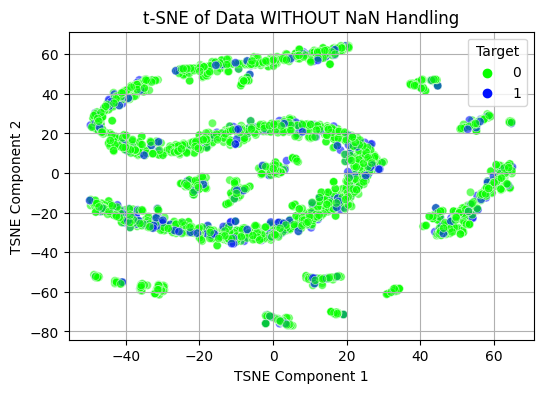

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
print("t-SNE Visualization for Data WITHOUT NaN Handling")
preprocess_and_tsne_with_nan_handling(X_valid, y_valid, 't-SNE of Data WITHOUT NaN Handling')

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff094e3a5f0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

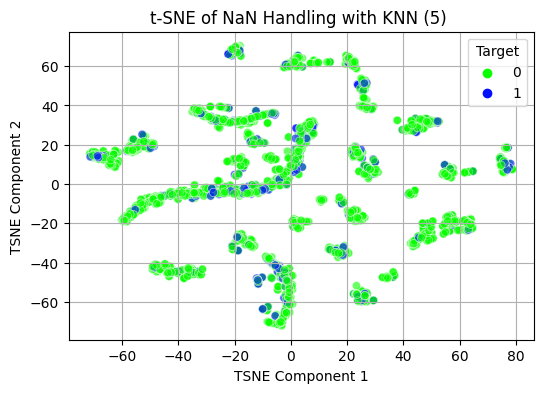

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed, y_valid, 't-SNE of NaN Handling with KNN (5) ')

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff094124ee0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

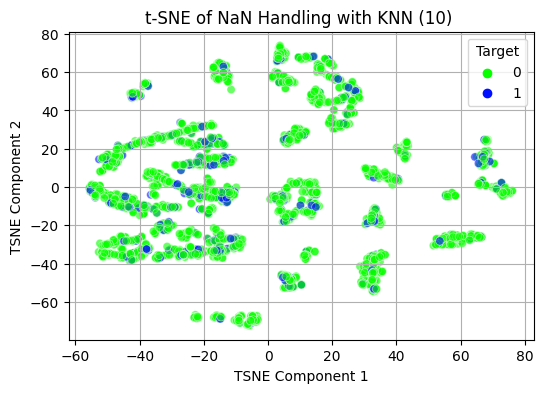

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_10, y_valid, 't-SNE of NaN Handling with KNN (10) ')

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff08efd3e20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

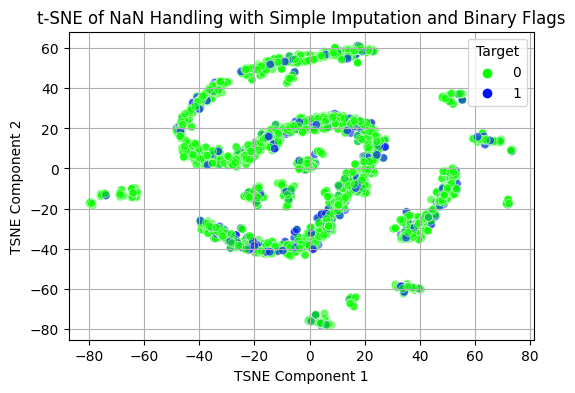

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed, y_valid, 't-SNE of NaN Handling with Simple Imputation and Binary Flags')

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff085b50430>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

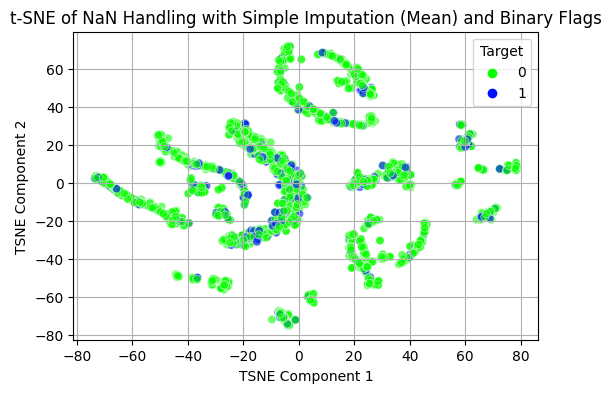

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed_average, y_valid, 't-SNE of NaN Handling with Simple Imputation (Mean) and Binary Flags')

We visually see that the patterns are more distinct when applying the Mean Target NaN imputation method, however, we are not able to do the same in the validation set, because we cannot use the target to impute the mead and mode by target. So we are training the model in this properly distinguishable model but then the predictions is in the non imputed one. We will check the scores in the next section. 

Hardcoding missing data as a different number of field.

### Post-Imputation Model Evaluation:

In [0]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    def safe_roc_auc_score(y_true, y_score):
        """ Compute ROC AUC score only if there are two unique values in y_true """
        if len(set(y_true)) < 2:
            return 0 
        else:
            return roc_auc_score(y_true, y_score)

    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2 * safe_roc_auc_score(x["target"], x["score"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

%md
Imputed KNN 5 neighbours

In [0]:
X_train_knn_imputed_5 = X_train_knn_imputed
X_valid_knn_imputed_5 = X_valid_knn_imputed

model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_knn_imputed_5, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_knn_imputed_5)[:, 1]
y_valid_pred = model_mean.predict(X_valid_knn_imputed_5)

# Evaluate the model
name='lightGBM with NaN KNN 5 neighbours Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_knn_imputed_5), (base_valid, X_valid_knn_imputed_5)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with NaN KNN 5 neighbours Inputed ---
AUC: 0.7646
Precision: 0.5781
Recall: 0.0923
Accuracy: 0.8697
F1 Score: 0.1591

The stability score on the train set is: 0.8112734011382797
The stability score on the valid set is: 0.16352155583177344


Imputed KNN 10 neighbours


In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_knn_imputed_10, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_knn_imputed_10)[:, 1]
y_valid_pred = model_mean.predict(X_valid_knn_imputed_10)

# Evaluate the model
name='lightGBM with NaN Mean Target Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_knn_imputed_10), (base_valid, X_valid_knn_imputed_10)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with NaN Mean Target Inputed ---
AUC: 0.7807
Precision: 0.5758
Recall: 0.0948
Accuracy: 0.8697
F1 Score: 0.1627

The stability score on the train set is: 0.8112734011382797
The stability score on the valid set is: -0.028288709030278414


We see that the accuracy slightly drops and that the recall is dropping as well. As we see that the positive targets are spread around the space when imputing the mean of the neihbourgs we are pulling from the sourranding non positive class, which makes it even more difficult to distinguish. 

Imputed Median Simple Imputer and Numerical Missing Binary Flag

In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed)

# Evaluate the model
name='lightGBM with NaN Imputer Median Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_imputed), (base_valid, X_valid_imputed)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with NaN Imputer Median Simple Imputer and Binary Flag ---
AUC: 0.7820
Precision: 0.5057
Recall: 0.1097
Accuracy: 0.8667
F1 Score: 0.1803

The stability score on the train set is: 0.8168764453298893
The stability score on the valid set is: 0.1073786805247357


The Recall seems to descent... 

Imputed Mean Simple Imputer and Numerical Missing Binary Flag

In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed_average)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed_average)

# Evaluate the model
name='lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_imputed_average), (base_valid, X_valid_imputed_average)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag ---
AUC: 0.7283
Precision: 0.4104
Recall: 0.1771
Accuracy: 0.8560
F1 Score: 0.2474

The stability score on the train set is: 0.8277679430136518
The stability score on the valid set is: 0.1318468171491848


We get a slight improvement in the recall. We will move forward with this imputation method. 

# 3. Standardization of the Data

We need to standardize the data before applying the variation threshold and other more complex transformations

We will compare between Standard Scaler and Robust Scaler (robust to outliers using statistics like median and interquantile range)

In [0]:
# Initialize RobustScaler
robust_scaler = RobustScaler()
std_scaler = StandardScaler()


# Fit and transform on training data, transform on validation data
X_train_scaled_robust = robust_scaler.fit_transform(X_train_imputed_average)
X_valid_scaled_robust = robust_scaler.transform(X_valid_imputed_average)

X_train_scaled_std = std_scaler.fit_transform(X_train_imputed_average)
X_valid_scaled_std = std_scaler.transform(X_valid_imputed_average)

# Convert back to DataFrame
X_train_scaled_robust = pd.DataFrame(X_train_scaled_robust, columns=X_train_imputed_average.columns)
X_valid_scaled_robust = pd.DataFrame(X_valid_scaled_robust, columns=X_valid_imputed_average.columns)

X_train_scaled_robust = pd.DataFrame(X_train_scaled_std, columns=X_train_imputed_average.columns)
X_valid_scaled_robust = pd.DataFrame(X_valid_scaled_std, columns=X_valid_imputed_average.columns)

Let's check the model performance, we do not expect a drastic change because the tree based model are not highly affected by the scale of the features. We are doing scaling to be able to apply other distance based dimension reduction methods

In [0]:
model_scaled = LGBMClassifier(random_state=1)
# Fit the model
model_scaled.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_scaled.predict_proba(X_valid_scaled_std)[:, 1]
y_valid_pred = model_scaled.predict(X_valid_scaled_std)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_scaled_std), (base_valid, X_valid_scaled_std)]:
    y_pred = model_scaled.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with Scaled Features with StandardScaler Scaler ---
AUC: 0.5185
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.8663
F1 Score: 0.0000

The stability score on the train set is: -0.055495616737953626
The stability score on the valid set is: -0.27473842779152263


The perfomance of the model degrades, it might be because the outliers is were the positive class information lays. 

Same as before... We are going to investigate if after applying dimensionality reduction the predictive power of the model can increase back.

# 4. Threshold Variance

We apply threshold variance so the dimensionality algorithms are faster to compute. 

In [0]:
# Apply VarianceThreshold to remove low-variance features
varianceThreshold = VarianceThreshold(threshold=0.1)
X_train_reduced = varianceThreshold.fit_transform(X_train_scaled_std)
X_valid_reduced = varianceThreshold.transform(X_valid_scaled_std)

In [0]:
X_train_scaled_std.shape

(7000, 3752)

In [0]:
X_train_reduced.shape

(7000, 3432)

We reduce the dataset on 300 columns aproximately

# 5. Dimensionality Reduction Algorithms


Dimensionality Reduction Algorithms
Principal Component Analysis (PCA)

Description: PCA is a linear dimensionality reduction technique that transforms the data into a set of orthogonal components that capture the maximum variance.
Advantages:
Handles large datasets efficiently.
Reduces dimensionality while retaining as much variance as possible.
Limitations:
Assumes linear relationships.
May not perform well if the data is not linearly separable.
Suitability: Good for initial dimensionality reduction, especially when combined with other methods.
Linear Discriminant Analysis (LDA)

Description: LDA is a supervised technique that maximizes the separation between multiple classes.
Advantages:
Focuses on maximizing class separability.
Useful for classification tasks.
Limitations:
Assumes normally distributed classes with equal covariance matrices.
Limited to supervised settings.
Suitability: Best when the goal is to enhance class separability, especially in classification problems.
t-Distributed Stochastic Neighbor Embedding (t-SNE)

Description: t-SNE is a non-linear technique that visualizes high-dimensional data in lower dimensions by preserving local similarities.
Advantages:
Excellent for visualizing clusters.
Captures non-linear relationships.
Limitations:
Computationally intensive.
Primarily used for visualization rather than feature reduction for modeling.
Suitability: Best for visualizing complex patterns and clusters.
Uniform Manifold Approximation and Projection (UMAP)

We apply PCA and again we visualize with t-SNE

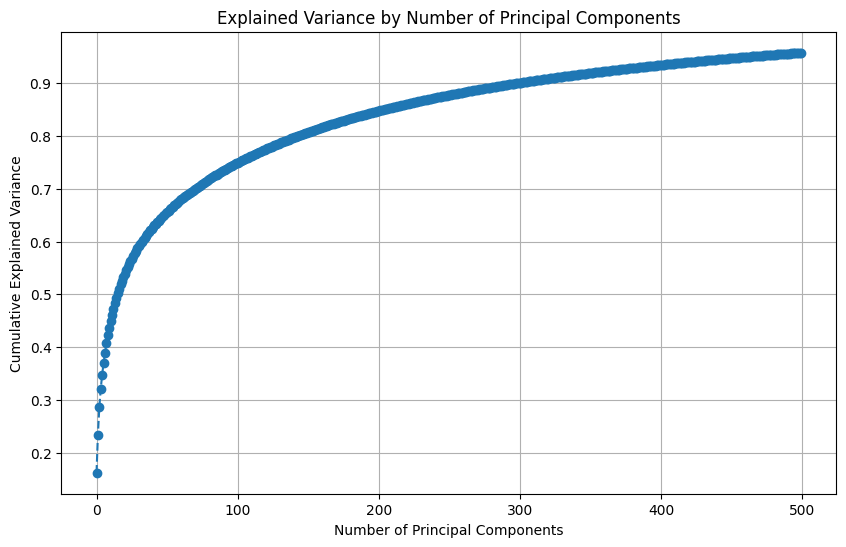

In [0]:
# Apply PCA on scaled and reduced training data
pca = PCA(n_components=500)  # Adjust n_components as needed
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_valid_reduced_pca = pca.transform(X_valid_reduced)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

We would like to keep 95% of explained variance, so we would transform the space into 500 principal componenets

In [0]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def tsne_plot(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
        
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.3

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

    print("t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling")

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff08c1c8d30>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __i

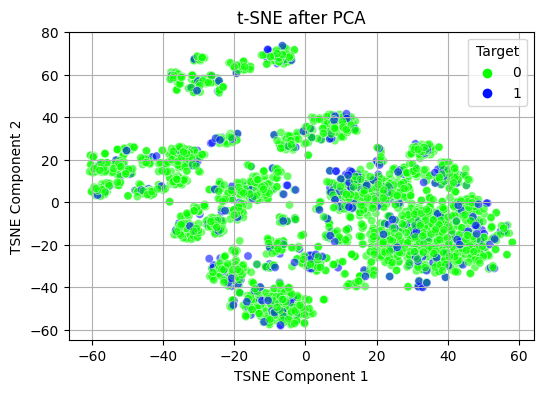

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_valid_reduced_pca, y_valid, 't-SNE after PCA')


We see that after PCA it is not easier to distinguish between both..

Using other dimensionality Reduction Algorithm LDA: Linear Discriminant Analysis.

Number of Components=min(Number of Classes−1,Number of Features)

In [0]:
# Apply LDA on training data
lda = LDA(n_components=1)  # n_components based on the number of classes
X_train_reduced_lda = lda.fit_transform(X_train_reduced, y_train)
X_valid_reduced_lda = lda.transform(X_valid_reduced)

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


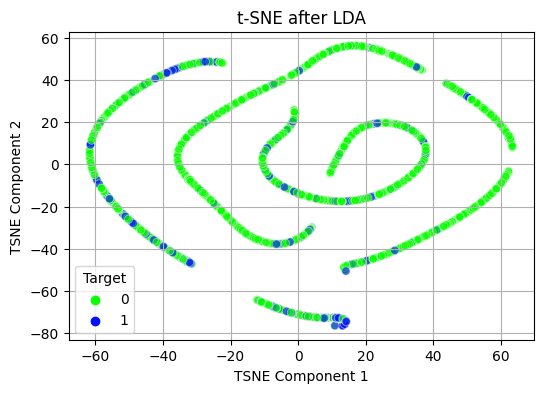

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_valid_reduced_lda, y_valid, 't-SNE after LDA')

### Post-Dimensionality Reduction Evaluation:

Purpose: Evaluate how dimensionality reduction affects model performance

In [0]:
model_reduced = LGBMClassifier(random_state=1)
# Fit the model
model_reduced.fit(X_train_reduced_lda, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_reduced.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = model_reduced.predict(X_valid_reduced_lda)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and LDA'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

for base, X in [(base_train, X_train_reduced_lda), (base_valid, X_valid_reduced_lda)]:
    y_pred = model_reduced.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA ---
AUC: 0.7071
Precision: 0.3965
Recall: 0.2818
Accuracy: 0.8467
F1 Score: 0.3294

The stability score on the train set is: 0.7246640826652294
The stability score on the valid set is: -0.03913611889690205


Comparing it with the baseline model, we get an improvement in the overall resutls. Except for the stability on the validation set. We will try to solve this by including regularization in the LightGBM model 

# 6. Handling Class inbalance applying  SMOTE on training data

In [0]:
# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced_lda, y_train)
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_valid_reduced_lda, y_valid)

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


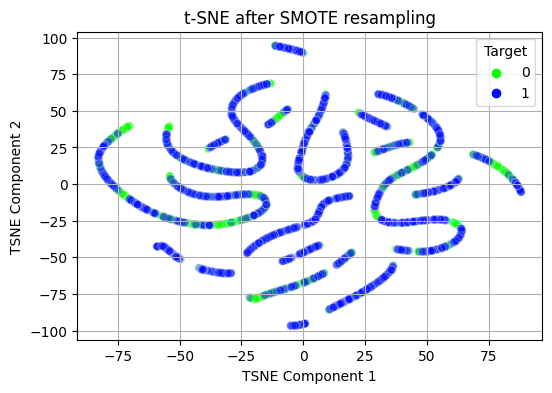

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_valid_resampled, y_valid_resampled, 't-SNE after SMOTE resampling')

### SMOTE evaluation Evaluation:


In [0]:

model_balanced = LGBMClassifier(random_state=1)
# Fit the model
model_balanced.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and classes
y_valid_pred_probs = model_balanced.predict_proba(X_valid_resampled)[:, 1]
y_valid_pred = model_balanced.predict(X_valid_resampled)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE'
evaluate_model(name, y_valid_resampled, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE ---
AUC: 0.7043
Precision: 0.6787
Recall: 0.5421
Accuracy: 0.6427
F1 Score: 0.6028



# 5. Final Model Evaluation after adding hyperparameter tunning and Regularization

**Comparison of LightGBM Performance: Baseline vs Tunned Model**

In [0]:
  # LightGBM hyperparameters grid for tuning
param_grid = {
  'num_leaves': [20, 31, 40, 50, 60],
  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [-1, 10, 15, 20, 25],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0.0, 0.1, 0.5, 1.0],
  'reg_lambda': [0.0, 0.1, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# Initialize the LGBMClassifier
model = LGBMClassifier(random_state=1)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2,
    random_state=1
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = random_search.best_estimator_

# Predict probabilities and classes
y_valid_pred_probs = best_model.predict_proba(X_valid_resampled)[:, 1]
y_valid_pred = best_model.predict(X_valid_resampled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


# Regularization

In [0]:
best_model

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=15,
               min_child_weight=7, n_estimators=200, num_leaves=40,
               objective='tweedie', random_state=1, reg_alpha=0.5,
               reg_lambda=1.0, subsample=0.6)


**L1 Penalty**  reg_alpha adds a penalty equivalent to the absolute value of the magnitude of coefficients (L1 penalty) to the loss function.
It  Encourages sparsity, meaning it can drive some coefficients to zero. Helps in feature selection by potentially eliminating less important features.

Best model Value: reg_alpha=0.5. Moderate L1 Regularization: A value of 0.5 indicates a moderate level of L1 regularization, encouraging sparsity but not too aggressively.

**L2 Penalty** reg_lambda adds a penalty equivalent to the square of the magnitude of coefficients (L2 penalty) to the loss function. Penalizes large coefficients more heavily.
Helps in reducing model complexity and overfitting.

Best model Value:  reg_lambda=1. A value of 1 indicates a standard level of L2 regularization, providing a balanced regularization effect.

In [0]:
# Evaluate the tuned model
name = 'LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning'
evaluate_model(name, y_valid_resampled, y_valid_pred, y_valid_pred_probs)

--- LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning ---
AUC: 0.7043
Precision: 0.6817
Recall: 0.5594
Accuracy: 0.6491
F1 Score: 0.6145



### Analysis of Validation Results Performance Metrics
Metrics Comparison with the basic baseline (random weight model):
- The AUC has decreased, indicating that the overall discrimination ability between the positive and negative classes has reduced slightly. This decrease is likely due to the transformations and balancing, which have altered the feature space and class distributions, focusing more on recall improvement.
- Precision has improved significantly. The higher precision indicates that the improved model is better at correctly identifying true positives among the predicted positives, reducing false positives.
- Recall has increased dramatically, showing that the improved model is much more effective at identifying actual positive cases. This improvement is crucial since the focus is on predicting true positives.
- Accuracy has decreased, which is expected in imbalanced datasets when improving recall and precision. The decrease indicates a shift in focus from overall correctness to correctly identifying the minority class.
- The F1 Score, which balances precision and recall, has significantly improved. This indicates a better overall balance between precision and recall, enhancing the model's effectiveness in handling the imbalanced dataset.


## Interpretation and Potential Reasons for changes: 
- Imputation and Binary Flags: Adding binary flags for missing data and imputing with the mean added valuable information, helping the model distinguish between observed and missing data points more effectively.
- LDA maximized class separability by projecting the data into a space that emphasized differences between classes. Impact: This contributed to significant improvements in recall and precision by creating a more distinct separation between classes.
- SMOTE balanced the dataset by generating synthetic samples for the minority class, providing the model with more balanced training data. Impact: This directly improved recall by providing more examples of the minority class, allowing the model to better learn its characteristics.
- Regularization parameters (reg_alpha and reg_lambda) helped control overfitting, ensuring the model generalized better to unseen data.

# Conclusion
Recall and Precision: The improved model shows substantial gains in recall and precision, making it much more effective at identifying true positives and reducing false positives.
F1 Score: The significant improvement in the F1 Score indicates a better balance between precision and recall, enhancing the model’s overall effectiveness.
AUC and Accuracy: While these metrics decreased, the improvements in recall and precision are more critical for the goal of predicting true positives.

The model with imputed mean, binary missing flags, scaling, LDA, SMOTE, regularization, and randomized hyperparameter tuning is more effective in identifying true positives in an imbalanced dataset with many missing values.
Focus: The preprocessing and tuning steps have shifted the model’s focus towards better handling of the minority class, resulting in better recall and precision, which are crucial for predicting true positives.